In [18]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
from PIL import Image
import numpy as np
from sklearn.model_selection import StratifiedKFold
from RandAugment import RandAugment
from pathlib import Path
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

In [19]:
source_dir = '/scratch/ssd004/scratch/junejory/'
train_dir = '/scratch/ssd004/scratch/junejory/train2019'
val_dir = '/scratch/ssd004/scratch/junejory/val2019'
train_json = '/scratch/ssd004/scratch/junejory/train2019.json'
val_json = '/scratch/ssd004/scratch/junejory/val2019.json'
categories_json = '/scratch/ssd004/scratch/junejory/categories.json'
rsource_dir = '/datasets/inat_comp/2019/train_val2019'

In [20]:
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [21]:
train_data = load_json(train_json)
val_data = load_json(val_json)

In [22]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [23]:
walk_through_dir(rsource_dir)

There are 6 directories and 0 images in '/datasets/inat_comp/2019/train_val2019'.
There are 10 directories and 0 images in '/datasets/inat_comp/2019/train_val2019/Amphibians'.
There are 0 directories and 126 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/157'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/160'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/161'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/153'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/158'.
There are 0 directories and 55 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/154'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/159'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/155'.
There are 0 directories and 503 i

In [24]:
# import random
# from PIL import Image

# # Set seed
# random.seed(42) # <- try changing this and see what happens

# # 1. Get all image paths (* means "any combination")
# image_path_list = list(image_path.glob("*/*/*.jpg"))

# # 2. Get random image path
# random_image_path = random.choice(image_path_list)

# # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
# image_class = random_image_path.parent.stem

# # 4. Open image
# img = Image.open(random_image_path)

# # 5. Print metadata
# print(f"Random image path: {random_image_path}")
# print(f"Image class: {image_class}")
# print(f"Image height: {img.height}") 
# print(f"Image width: {img.width}")
# img

In [25]:
tp = Path(rsource_dir)
image_path = tp
if image_path.is_dir():
    print(f"{image_path} directory exists.")

/datasets/inat_comp/2019/train_val2019 directory exists.


In [26]:
image_path

PosixPath('/datasets/inat_comp/2019/train_val2019')

In [27]:
walk_through_dir(image_path)

There are 6 directories and 0 images in '/datasets/inat_comp/2019/train_val2019'.
There are 10 directories and 0 images in '/datasets/inat_comp/2019/train_val2019/Amphibians'.
There are 0 directories and 126 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/157'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/160'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/161'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/153'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/158'.
There are 0 directories and 55 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/154'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/159'.
There are 0 directories and 503 images in '/datasets/inat_comp/2019/train_val2019/Amphibians/155'.
There are 0 directories and 503 i

Random image path: /datasets/inat_comp/2019/train_val2019/Plants/383/97ab37287b67f3877a93a7a29c2f5b4f.jpg
Image class: 383
Image height: 800
Image width: 450


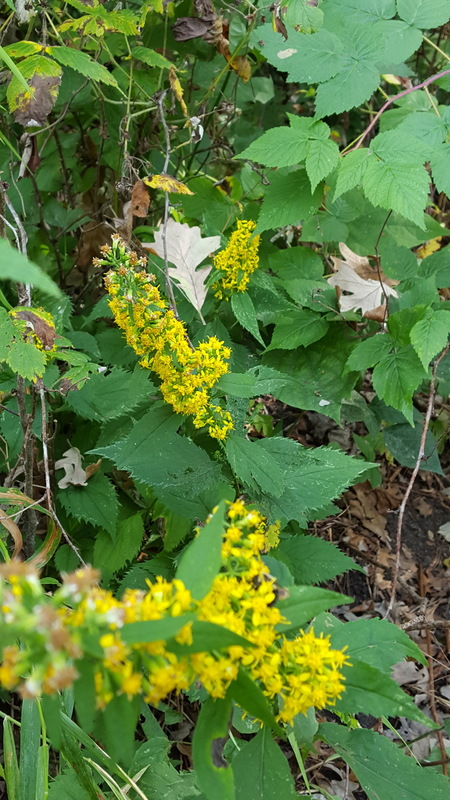

In [28]:
import random
from PIL import Image

# Set seed
random.seed(45) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

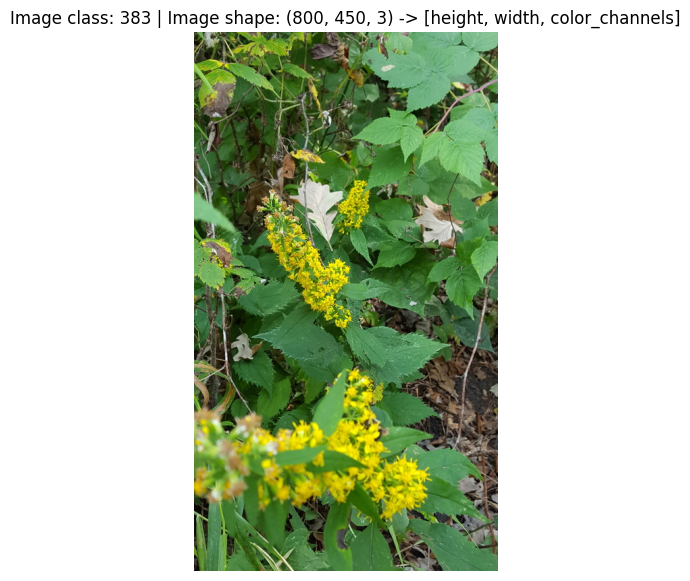

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [30]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=9, magnitude=int(0.5)), #9 Augmentations with Magnitude 0.5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


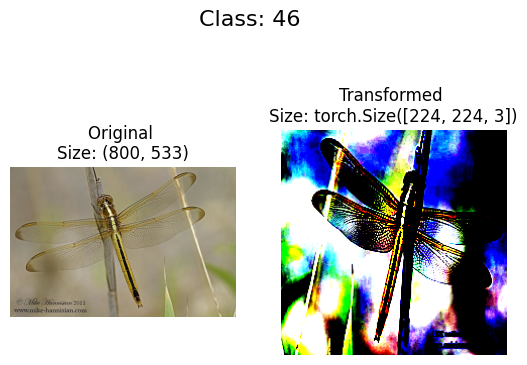

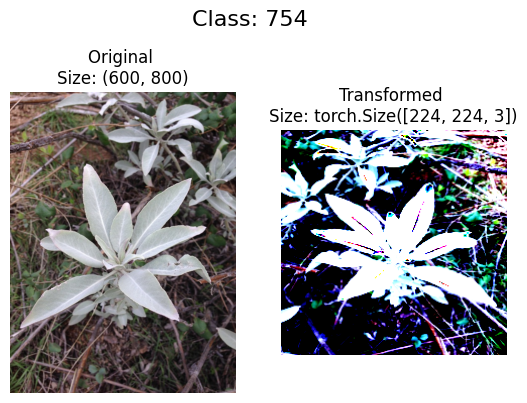

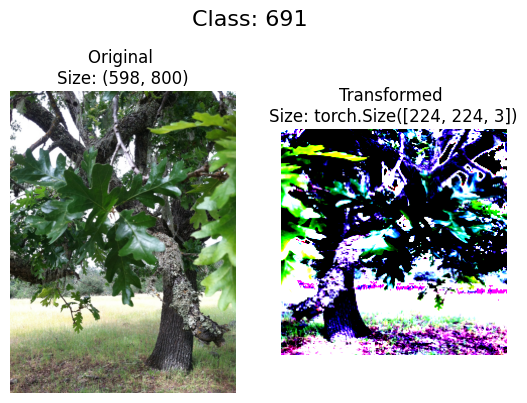

In [31]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=100):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [46]:
def get_image_data(annotations):
    images = {img['id']: img['file_name'] for img in annotations['images']}
    img_to_annotations = {ann['image_id']: ann['category_id'] for ann in annotations['annotations']}
    return images, img_to_annotations

train_images, train_img_to_annotations = get_image_data(train_data)
val_images, val_img_to_annotations = get_image_data(val_data)

# Custom Dataset class for iNaturalist
class INatDataset(Dataset):
    def __init__(self, image_dict, img_to_annotations, root_dir, transform=None):
        self.image_dict = image_dict
        self.img_to_annotations = img_to_annotations
        self.root_dir = root_dir
        self.transform = data_transform

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        print(f"Fetching index {idx} of {len(self.image_dict)}")
        img_id = list(self.image_dict.keys())[idx]
        img_name = self.image_dict[img_id]
        img_path = os.path.join(self.root_dir, img_name)
        
        # Print the image ID and path
        print(f"Image ID: {img_id}, Image Path: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        label = self.img_to_annotations[img_id]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define root directory and create dataset instances
root_dir = '/datasets/inat_comp/2019/'
train_dataset = INatDataset(train_images, train_img_to_annotations, root_dir, transform=data_transform)
val_dataset = INatDataset(val_images, val_img_to_annotations, root_dir, transform=data_transform)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [48]:
try:
    for i in range(len(val_dataset)):
        image, label = val_dataset.__getitem__(i)
        print(f"Fetched image with label {label}")
except Exception as e:
    print(f"Error occurred: {e}")

Fetching index 0 of 3030
Image ID: 265213, Image Path: /datasets/inat_comp/2019/train_val2019/Plants/644/716a69838526f3ada3b2fe2e099cfcb6.jpg
Fetched image with label 644
Fetching index 1 of 3030
Image ID: 265214, Image Path: /datasets/inat_comp/2019/train_val2019/Plants/597/0942cc64d2e759c5ee05970d8170942c.jpg
Fetched image with label 597
Fetching index 2 of 3030
Image ID: 265215, Image Path: /datasets/inat_comp/2019/train_val2019/Plants/883/acfdbfd9fa675f1c84558e3b9239db90.jpg
Fetched image with label 883
Fetching index 3 of 3030
Image ID: 265216, Image Path: /datasets/inat_comp/2019/train_val2019/Birds/300/5f3194ff536c7dd31d80b78ef809bc23.jpg
Fetched image with label 300
Fetching index 4 of 3030
Image ID: 265217, Image Path: /datasets/inat_comp/2019/train_val2019/Plants/881/76acaf0b2841f91982d2197cff825014.jpg
Fetched image with label 881
Fetching index 5 of 3030
Image ID: 265218, Image Path: /datasets/inat_comp/2019/train_val2019/Plants/771/5d190fd90da893988a3c9043b607fd24.jpg
Fetc

In [35]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X=list(train_images.keys()), y=list(train_img_to_annotations.values()))):
    print(f"Fold {fold+1}/{n_splits}")
    # Split data
    train_subset = Subset(train_dataset, train_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [36]:
print(f"Total images in train_images: {len(train_images)}")
print(f"Total images in val_images: {len(val_images)}")
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of val_dataset: {len(val_dataset)}")
print(f"Train subset size: {len(train_idx)}")
print(f"Validation subset size: {len(val_idx)}")

Total images in train_images: 265213
Total images in val_images: 3030
Length of train_dataset: 265213
Length of val_dataset: 3030
Train subset size: 212171
Validation subset size: 53042


In [46]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X=list(train_images.keys()), y=list(train_img_to_annotations.values()))):
    print(f"Fold {fold+1}/{n_splits}")
    # Split data
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Model, optimizer, scheduler
    model = torch.hub.load("facebookresearch/hiera", model="hiera_tiny_224", pretrained=True, checkpoint="mae_in1k")
    model.head.projection = nn.Linear(in_features=model.head.projection.in_features, out_features=num_classes)
    model = model.to(device)

    finetune_optimizer = optim.AdamW(model.parameters(), lr=2e-3, betas=(0.9, 0.999), weight_decay=0.05)
    finetune_scheduler = CosineAnnealingLR(finetune_optimizer, T_max=50, eta_min=0)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    writer = SummaryWriter(log_dir=f'logs/hiera_transfer_fold_{fold+1}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    
    scaler = GradScaler()
    num_epochs = 300

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            finetune_optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(finetune_optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        # Validation loop
        model.eval()
        val_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = corrects.double() / len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/validation', accuracy, epoch)

        finetune_scheduler.step()

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s')

    writer.close()
    torch.save(model.state_dict(), f'hiera_inat2019_fold_{fold+1}.pth')
    

Fold 1/5


Using cache found in /h/junejory/.cache/torch/hub/facebookresearch_hiera_main


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


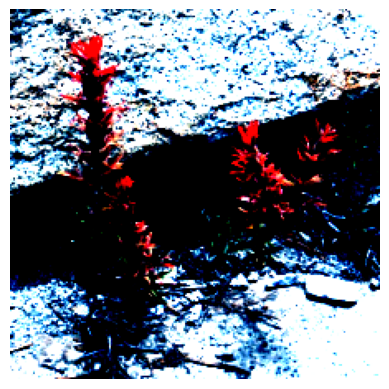

Image tensor shape: torch.Size([3, 224, 224])
Image type: <class 'torch.Tensor'>
Label type: <class 'int'>


In [16]:
# Example usage of INatDataset and __getitem__ method
train_dataset = INatDataset(train_images, train_img_to_annotations, root_dir, transform=data_transform)

# Test the __getitem__ method with an example index
index = 15  # You can try different indices
image, label = train_dataset[index]

def show_image(image_tensor):
    # If normalization was applied, you might need to reverse it here.
    # image_tensor = reverse_transform(image_tensor)
    image = image_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display the image using matplotlib
show_image(image)

# To verify the data type and shape
print(f"Image tensor shape: {image.shape}")
print(f"Image type: {type(image)}")
print(f"Label type: {type(label)}")


In [17]:
val_iter = iter(val_loader)
images, labels = next(val_iter)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Labels: {labels[:10]}")  # Print the first 10 labels
print(f"Image data type: {type(images)}")
print(f"Labels data type: {type(labels)}")

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels: tensor([644, 597, 883, 300, 881, 771, 607, 698, 714, 316])
Image data type: <class 'torch.Tensor'>
Labels data type: <class 'torch.Tensor'>


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
from torch import Tensor
# Define the DropPath function
def drop_path(x: Tensor, keep_prob: float = 1.0, inplace: bool = False) -> Tensor:
    mask_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    mask = x.new_empty(mask_shape).bernoulli_(keep_prob)
    mask.div_(keep_prob)
    if inplace:
        x.mul_(mask)
    else:
        x = x * mask
    return x

# Define the DropPath module
class DropPath(nn.Module):
    def __init__(self, p: float = 0.5, inplace: bool = False):
        super().__init__()
        self.p = p
        self.inplace = inplace

    def forward(self, x: Tensor) -> Tensor:
        if self.training and self.p > 0:
            x = drop_path(x, self.p, self.inplace)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"

# Modify the Bottleneck block to include DropPath
class ConvBnAct(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, kernel_size=1):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(out_features),
            nn.ReLU()
        )

class BottleNeck(nn.Module):
    def __init__(self, in_features: int, out_features: int, reduction: int = 4, drop_prob: float = 0.1):
        super().__init__()
        self.block = nn.Sequential(
            ConvBnAct(in_features, out_features // reduction, kernel_size=1),
            ConvBnAct(out_features // reduction, out_features // reduction, kernel_size=3),
            ConvBnAct(out_features // reduction, out_features, kernel_size=1),
        )
        self.drop_path = DropPath(p=drop_prob)
        
    def forward(self, x: Tensor) -> Tensor:
        res = x
        x = self.block(x)
        x = self.drop_path(x)
        return x + res

In [20]:
cat_data = load_json('/scratch/ssd004/scratch/junejory/categories.json')
num_classes = len(cat_data)
print(num_classes)
model = torch.hub.load("facebookresearch/hiera", model="hiera_tiny_224", pretrained=True, checkpoint="mae_in1k")
for name, module in model.named_children():
    if isinstance(module, BottleNeck):
        setattr(model, name, BottleNeck(module.in_features, module.out_features, drop_prob=0.1))
model.head.projection = nn.Linear(in_features=model.head.projection.in_features, out_features=num_classes)
model = model.to(device)

1010


Using cache found in /h/junejory/.cache/torch/hub/facebookresearch_hiera_main


In [21]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    #print(f'{idx}: {name}')
layer_names.reverse()
#layer_names[0:5]


In [22]:
# learning rate
lr      = 3e-3    #adjusted so first layer is 2e-3
lr_mult = 0.65

# placeholder
parameters      = []
prev_group_name = layer_names[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # parameter group name
    if name == "pos_embed":
        pass
    else:
        cur_group_name = name.split('.')[1]
        # update learning rate
        if cur_group_name == "weight":
            pass
        elif cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name
    
    # display info
    #print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

In [23]:
finetune_optimizer = optim.AdamW(parameters, lr=2e-3, betas=(0.9, 0.999), weight_decay=0.05)
finetune_scheduler = CosineAnnealingLR(finetune_optimizer, T_max=50, eta_min=0)
finetune_epochs = 300
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [24]:
# Additional augmentations
from torchvision.transforms import v2
mixup_alpha = 0.8
cutmix_alpha = 1.0
cutmix = v2.CutMix(num_classes=num_classes)
mixup = v2.MixUp(num_classes=num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

writer = SummaryWriter(log_dir=f'logs/hiera_transfer_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [25]:
len(train_loader)

8288

In [31]:
# Fine-tuning
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()


for epoch in range(finetune_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

#    torch.cuda.empty_cache()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
        #labels = labels.squeeze()
        #print(labels)
            inputs,labels = cutmix_or_mixup(inputs,labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        finetune_optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(finetune_optimizer)
        scaler.update()

        #print("calculating loss")
        
        """if mixup_alpha > 0:
            #print("mixing alpha")
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            #print("not mixing alpha")"""
            
        
        # loss.backward()
        # finetune_optimizer.step()
        #print("finetune optimized")
        running_loss += loss.item() * inputs.size(0)
        #print("loss has been ran")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/300, Loss: {epoch_loss:.4f}')
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    #validation loop
    model.eval()
    val_loss = 0.0
    corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = corrects.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', accuracy, epoch)

    finetune_scheduler.step()

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s')

writer.close()

torch.save(model.state_dict(), 'hiera_inat2019_transfer_learned.pth')

Epoch 1/3, Loss: 6.8870
Validation Loss: 6.9168, Accuracy: 0.0056
Epoch 1 completed in 2m 24s
Epoch 2/3, Loss: 6.6605
Validation Loss: 6.9168, Accuracy: 0.0036
Epoch 2 completed in 2m 18s
Epoch 3/3, Loss: 6.5816
Validation Loss: 6.9165, Accuracy: 0.0043
Epoch 3 completed in 2m 18s
